# Dreambooth

The goal of this tutorial is to get demo how to fine tune an image generation model

## Imports

In [ ]:
from AIsaac.all import *
import fastcore.all as fc
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, PretrainedConfig,CLIPTextModel
from accelerate import Accelerator
import xformers # May need dev version
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel, StableDiffusionPipeline
from diffusers.optimization import get_scheduler
from functools import partial

import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF

from PIL import Image
import itertools, math, hashlib, random
from pathlib import Path
from itertools import zip_longest

from IPython.display import clear_output


/home/python3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


## Utils

In [ ]:
def decode(tokenizer, tokens, start_after='<|startoftext|>', end_at='<|endoftext|>'):
    _decoded = ds.tokenizer.decode(tokens)
    return _decoded[len(start_after):_decoded.find(end_at)].strip()

denorm = UnNormalize([.5],[.5])

In [ ]:
pretrained_model="CompVis/stable-diffusion-v1-4" 
cls_img_dir = Path("dreambooth/class")
img_dir = Path("dreambooth/cropped")

## Generate Class Images

In [ ]:
def hash_img(img): return hashlib.sha1(img.tobytes()).hexdigest()

In [ ]:
pipeline = DiffusionPipeline.from_pretrained(pretrained_model,
                        torch_dtype=torch.float32,safety_checker=None,revision=None).to("cuda")

for i in range(10):
    images = pipeline(["a photo of dog"]*8).images
    path = cls_img_dir / ('train' if random.random()<0.8 else 'valid')
    for i, image in enumerate(images): image.save(path/f"{hash_img(image)}.jpg")
    
del pipeline
clean_memory()

## Fine Tuning

#### Data Loading

In [ ]:
def transform(image,xmean=0.5,xstd=0.5): return (TF.to_tensor(TF.resize(image,512))-xmean)/xstd

class DBDataset(Dataset):
    def __init__(self, class_imgs, class_prompt, main_imgs, main_prompt): 
        fc.store_attr('class_imgs,class_prompt,main_imgs,main_prompt')
    def __len__(self): return len(self.main_imgs)
    def __getitem__(self, idx):
        cls_img, main_img = map(Image.open,[self.class_imgs[idx],self.main_imgs[idx]])
        cls_img, main_img = map(transform,[cls_img, main_img])               
        return (torch.stack([main_img,cls_img]), 
                (self.main_prompt,self.class_prompt))


In [ ]:
trn_ds = DBDataset(get_images(cls_img_dir/'train'),"a photo of dog",get_images(img_dir/'train'),"a photo of sks dog")
val_ds = DBDataset(get_images(cls_img_dir/'valid')[:10],"a photo of dog",get_images(img_dir/'valid'),"a photo of sks dog")

In [ ]:
from torch.utils.data import DataLoader
dls = DataLoaders(*map(partial(DataLoader,batch_size=None),[trn_ds,val_ds]))

#### Data Augmentation

In [ ]:
img_tfms = transforms.Compose([transforms.RandomCrop(512),
                               transforms.Normalize([0.5], [0.5])])

tokenizer = AutoTokenizer.from_pretrained(pretrained_model,
                                          subfolder="tokenizer",
                                          revision=None,use_fast=False,)
def lbl_tfms(yb,tokenizer=tokenizer):
    out = tokenizer(yb,
                    truncation=True, padding="max_length",
                    max_length=tokenizer.model_max_length,
                    return_tensors="pt",)
    return out.input_ids

#### Model

In [ ]:
class DreamBoothModel(nn.Module):
    def __init__(self): 
        super().__init__()
        self.unet = UNet2DConditionModel.from_pretrained(pretrained_model, 
                                                         subfolder="unet", 
                                                         revision=None)
        self.text_encoder = CLIPTextModel.from_pretrained(pretrained_model, 
                                                          subfolder="text_encoder", 
                                                          revision=None)
        
    def forward(self,x):        
        encoder_hidden_states = self.text_encoder(x[1])[0]
        return self.unet(x[5], x[4], encoder_hidden_states).sample.float()

#### Training CB

In [ ]:
class DreamBoothTrainCB(AccelerateCB):
    def __init__(self, mixed_precision="fp16",class_image_weight=0.5):
        self.class_image_weight = class_image_weight
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, trainer):
        '''Wraps model, opt, data in accelerate'''
        trainer.model,trainer.opt,trainer.dls.train,trainer.dls.valid = self.acc.prepare(
                 trainer.model, trainer.opt, trainer.dls.train, trainer.dls.valid)
        
        trainer.noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model, subfolder="scheduler")
        trainer.vae = AutoencoderKL.from_pretrained(pretrained_model, subfolder="vae", revision=None)        
        trainer.vae.requires_grad_(False)
        trainer.vae.to(self.acc.device, dtype=torch.float16)

    def before_batch(self,trainer):
        '''Calculates latents, noise, timesteps, noisy_latents'''        
        vae, scaling_factor = trainer.vae, trainer.vae.config.scaling_factor
        trainer.batch.append(vae.encode(trainer.batch[0].to(dtype=torch.float16)).latent_dist.sample()*scaling_factor )
        trainer.batch[0] = to_cpu(trainer.batch[0]) 
        trainer.batch.append(torch.randn_like(trainer.batch[2]).float())
        num_ts = trainer.noise_scheduler.config.num_train_timesteps
        trainer.batch.append(torch.randint(0, num_ts, (trainer.batch[2].shape[0],), device=trainer.batch[2].device))
        trainer.batch.append(trainer.noise_scheduler.add_noise(trainer.batch[2], trainer.batch[3], trainer.batch[4]))
                
    def predict(self,trainer): trainer.preds = trainer.model(trainer.batch)

    def get_loss(self,trainer): 
        '''Calculates loss for instance and class images'''
        model_pred, model_pred_prior = torch.chunk(trainer.preds, 2, dim=0)
        target, target_prior = torch.chunk(trainer.batch[3], 2, dim=0)
        loss = trainer.loss_func(model_pred,target, reduction="mean")
        prior_loss = trainer.loss_func(model_pred_prior, target_prior, reduction="mean")
        trainer.loss = ((1 - self.class_image_weight) * loss) +  (self.class_image_weight * prior_loss)
                
    def backward(self,trainer):
        '''backward pass + clip_grad'''
        self.acc.backward(trainer.loss)
        if self.acc.sync_gradients: self.acc.clip_grad_norm_(trainer.model.parameters(), 1.)
   
    def zero_grad(self,trainer): trainer.opt.zero_grad(set_to_none=True)

#### Fine Tune

In [ ]:
trainer = Trainer(dls,fc.bind(F.mse_loss,reduction="mean"),torch.optim.AdamW,
                    DreamBoothModel(),
                    callbacks=[DreamBoothTrainCB(class_image_weight=.25),
                               OneCycleSchedulerCB(),
                               BatchAugmentationCB((img_tfms,lbl_tfms)),
                               DeviceCB(),
                               MetricsCB(),
                               ProgressCB()]
                 )

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
trainer.summarize_callbacks()

,Step,Callback,Doc String
,before_fit,OneCycleSchedulerCB,Initializes Scheduler
,before_fit,DeviceCB,Moves model to device
,before_fit,ProgressCB,Initialize Fit Progress Bar
,before_fit,DreamBoothTrainCB,"Wraps model, opt, data in accelerate"
,before_epoch,ProgressCB,Initialize Epoch Progress Bar
,before_batch,BatchAugmentationCB,applies tfms in tfms list to appropriate items in batch
,before_batch,DeviceCB,moves batch to device
,before_batch,DreamBoothTrainCB,"Calculates latents, noise, timesteps, noisy_latents"
,predict,DreamBoothTrainCB,
,get_loss,DreamBoothTrainCB,Calculates loss for instance and class images


In [ ]:
trainer.fit(50,lr=5e-6)

,train,valid
0,0.125696,0.230318


,train,valid
1,0.232612,0.123332


,train,valid
2,0.066541,0.182517


,train,valid
3,0.161011,0.098295


,train,valid
4,0.112926,0.091012


,train,valid
5,0.185095,0.196490


,train,valid
6,0.101598,0.122647


,train,valid
7,0.106308,0.091670


,train,valid
8,0.169324,0.082453


,train,valid
9,0.107214,0.180169


,train,valid
10,0.118429,0.126893


,train,valid
11,0.181714,0.133622


,train,valid
12,0.159709,0.097678


,train,valid
13,0.235059,0.057040


,train,valid
14,0.072090,0.101951


,train,valid
15,0.153997,0.150678


,train,valid
16,0.110091,0.086789


,train,valid
17,0.141006,0.186996


,train,valid
18,0.218605,0.127136


,train,valid
19,0.084883,0.158228


,train,valid
20,0.117560,0.103090


,train,valid
21,0.117552,0.185017


,train,valid
22,0.148583,0.104637


,train,valid
23,0.173988,0.156446


,train,valid
24,0.176349,0.219658


,train,valid
25,0.091933,0.122982


,train,valid
26,0.114160,0.142323


,train,valid
27,0.127860,0.082527


,train,valid
28,0.173347,0.105327


,train,valid
29,0.185406,0.194762


,train,valid
30,0.105407,0.102940


,train,valid
31,0.130632,0.227918


,train,valid
32,0.140506,0.168911


,train,valid
33,0.046199,0.108546


,train,valid
34,0.107185,0.076605


,train,valid
35,0.133266,0.136607


,train,valid
36,0.120615,0.181331


,train,valid
37,0.170491,0.092342


,train,valid
38,0.198938,0.142778


,train,valid
39,0.073053,0.131693


,train,valid
40,0.087147,0.098189


,train,valid
41,0.178266,0.205903


,train,valid
42,0.099110,0.110045


,train,valid
43,0.133939,0.302774


,train,valid
44,0.085011,0.180767


,train,valid
45,0.138991,0.199966


,train,valid
46,0.112717,0.085119


,train,valid
47,0.276444,0.096584


,train,valid
48,0.132728,0.187248


,train,valid
49,0.149210,0.139900


## Save Model 

In [ ]:
output_dir="dreambooth/out"
uw_model = trainer.DreamBoothTrainCB.acc.unwrap_model(trainer.model)
pipeline = DiffusionPipeline.from_pretrained(
    pretrained_model,
    unet=uw_model.unet,
    text_encoder=uw_model.text_encoder,
    revision=None,
)
pipeline.save_pretrained(output_dir)

Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 27962.03it/s]
/home/python3.10/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## Generate New Images

a photo of sks dog in a bucket


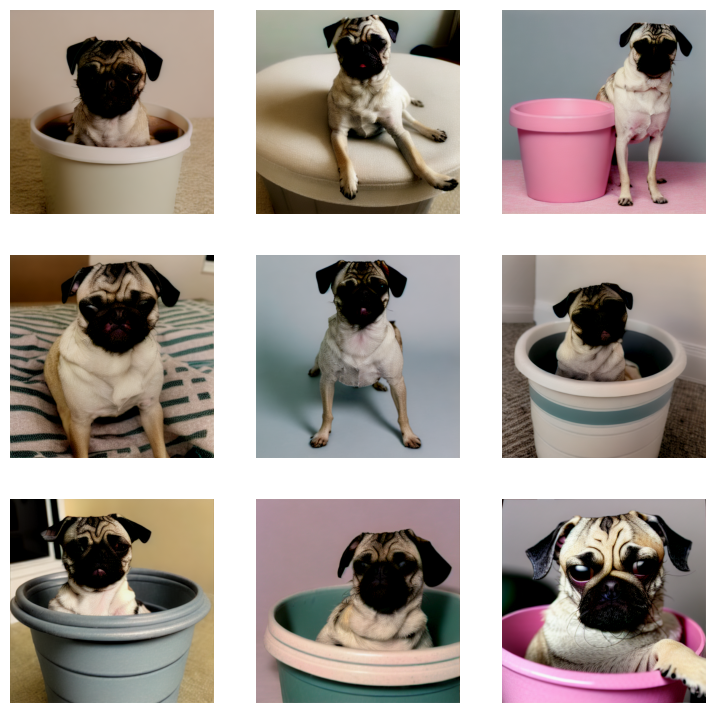

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(output_dir,safety_checker=None, torch_dtype=torch.float16).to("cuda")
prompt = "a photo of sks dog in a bucket"
    
images = [pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0] for i in range(9)]
clear_output()
print(prompt)
show_images(images)